In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'


from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-15 18:36:44.648930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 18:36:45.258306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


# Effects of lengthscale starting values and priors

We are trying to find the optimal lengthscale for our models. We seem to get very varied results when changing the epochs, the starting value and priors. This notebook aims to find (ideally) a prior that fixes this inconsistency. We will try:

1. Different priors both gamma and inverse-gamma with different parameter
2. Plotting the ELBO so possibly undetand what is happening better

In [3]:
def optimise_predict_model(model, epochs=50):
    elbos = []; ls = []; sigmas = []

    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()
        elbos.append(loss_fn().numpy())
        ls.append(model.kernel.lengthscales.numpy())
        sigmas.append(model.kernel.variance.numpy())
    
    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

    return elbos, ls, sigmas

Different distributions

No handles with labels found to put in legend.


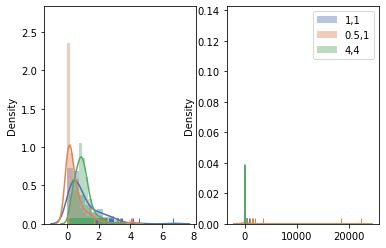

In [12]:
import warnings
warnings.filterwarnings("ignore")

# distribution of priors
g1 = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
g2 = tfp.distributions.Gamma(to_default_float(0.5), to_default_float(1))
g3 = tfp.distributions.Gamma(to_default_float(4), to_default_float(4))

ig1 = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
ig2 = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
ig3 = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(0.5))

sns_c = sns.color_palette(palette='deep')

data1 = g1.sample(200)
data2 = g2.sample(200)
data3 = g3.sample(200)

dat1 = ig1.sample(200)
dat2 = ig2.sample(200)
dat3 = ig3.sample(200)

fig, ax = plt.subplots(1,2)
sns.distplot(a=g1.sample(200), color=sns_c[0], rug=True, label='1,1', ax=ax[0]);
sns.distplot(a=g2.sample(200), color=sns_c[1], rug=True, label='0.5,1', ax=ax[0]);
sns.distplot(a=g3.sample(200), color=sns_c[2], rug=True, label='4,4', ax=ax[0]);
plt.legend()

sns.distplot(a=ig1.sample(200), color=sns_c[0], rug=True, label='1,1', ax=ax[1]);
sns.distplot(a=ig2.sample(200), color=sns_c[1], rug=True, label='0.5,1', ax=ax[1]);
sns.distplot(a=ig3.sample(200), color=sns_c[2], rug=True, label='4,4', ax=ax[1]);
plt.legend()

l Distribution:  tfp.distributions.InverseGamma("InverseGamma", batch_shape=[], event_shape=[], dtype=float64)


2022-08-15 18:37:13.046074: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-15 18:37:20.441469: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x816b4a0


Train


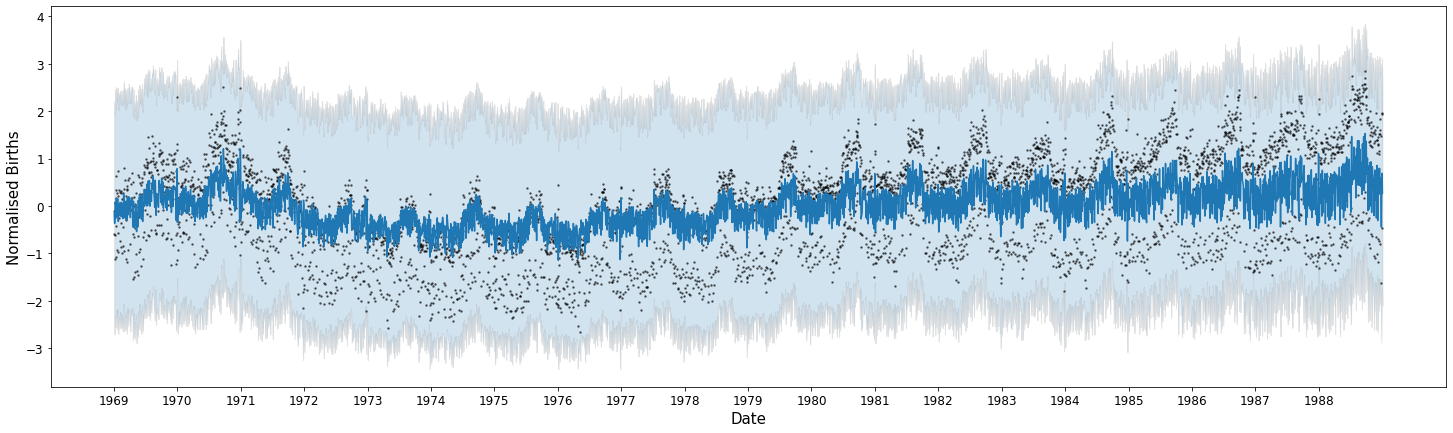

Test


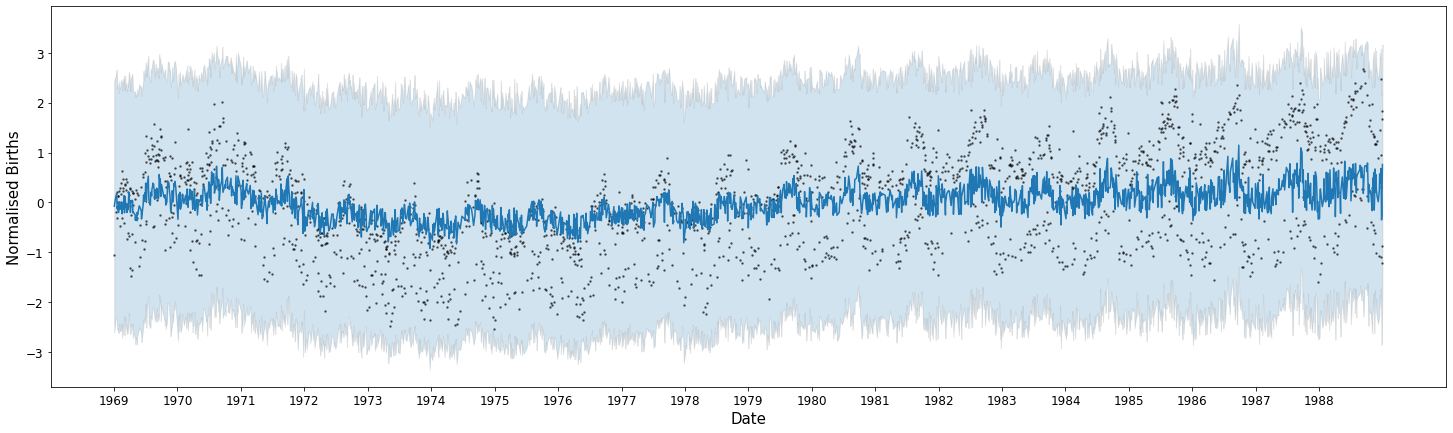

train ELBO, MSE, MAE:  -4515.645271992608 0.396352783735225 0.5254650704519637
test ELBO, MSE, MAE:  -5195.8858627038935 0.7179232997059299 0.7139534512755056
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
l Distribution:  tfp.distributions.InverseGamma("InverseGamma", batch_shape=[], event_shape=[], dtype=float64)
Train


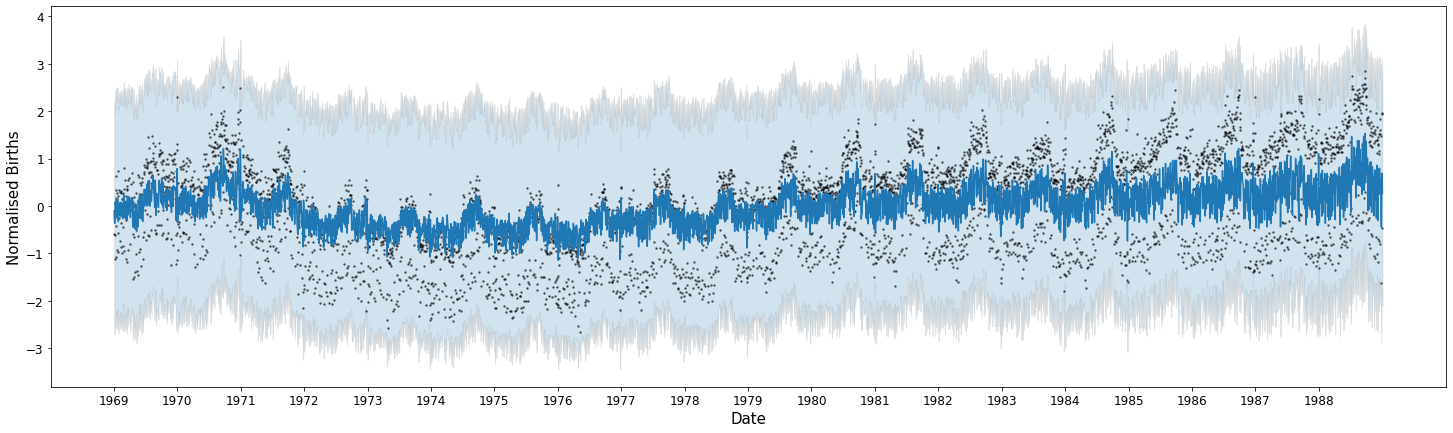

Test


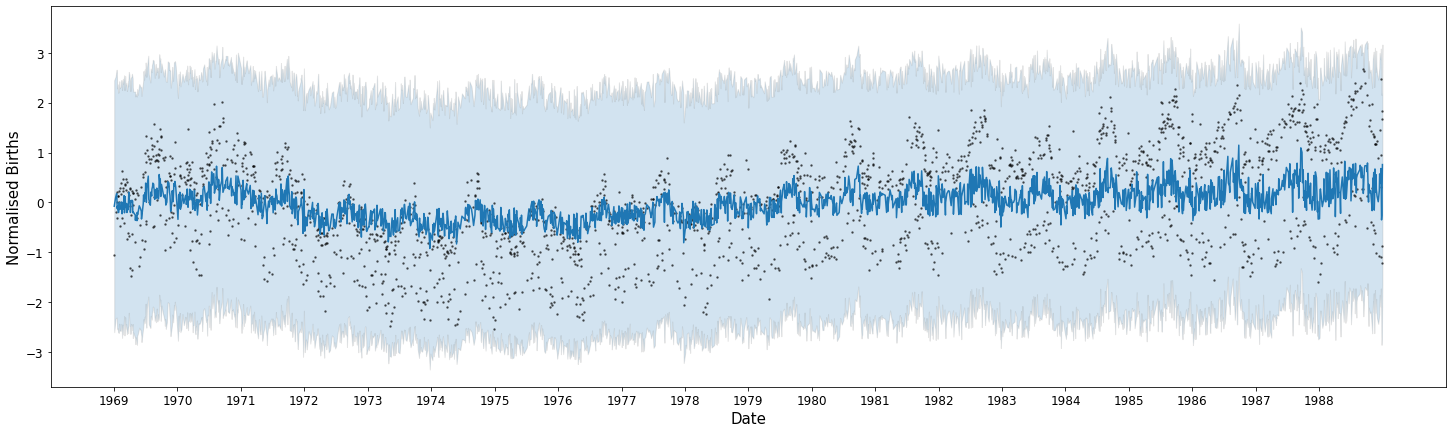

train ELBO, MSE, MAE:  -4515.642037070653 0.3963523526924564 0.5254647675833141
test ELBO, MSE, MAE:  -5195.880093660562 0.7179217876052888 0.7139527066224323
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
l Distribution:  tfp.distributions.Gamma("Gamma", batch_shape=[], event_shape=[], dtype=float64)
Train


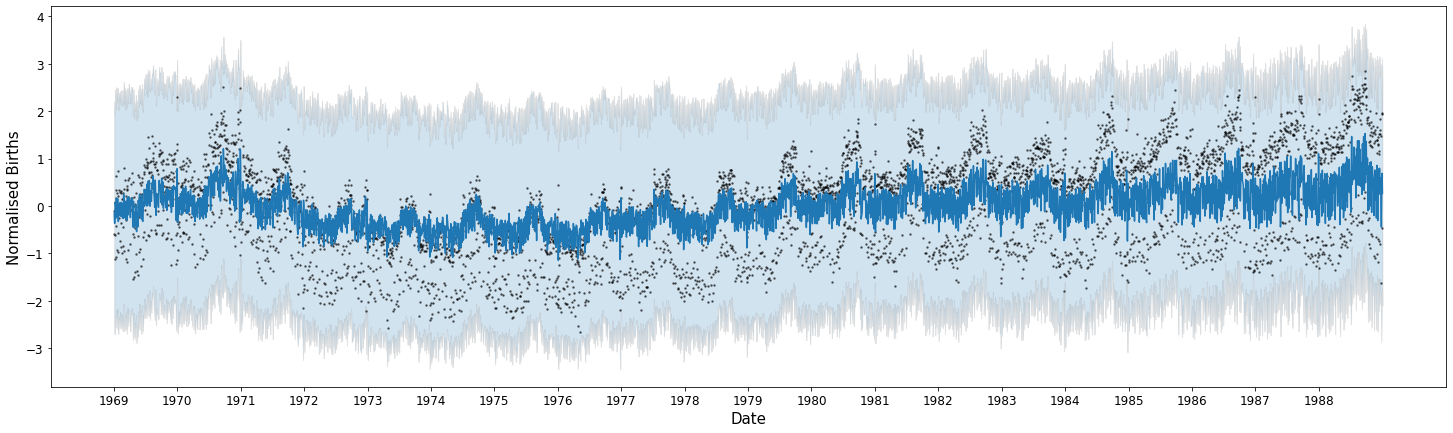

Test


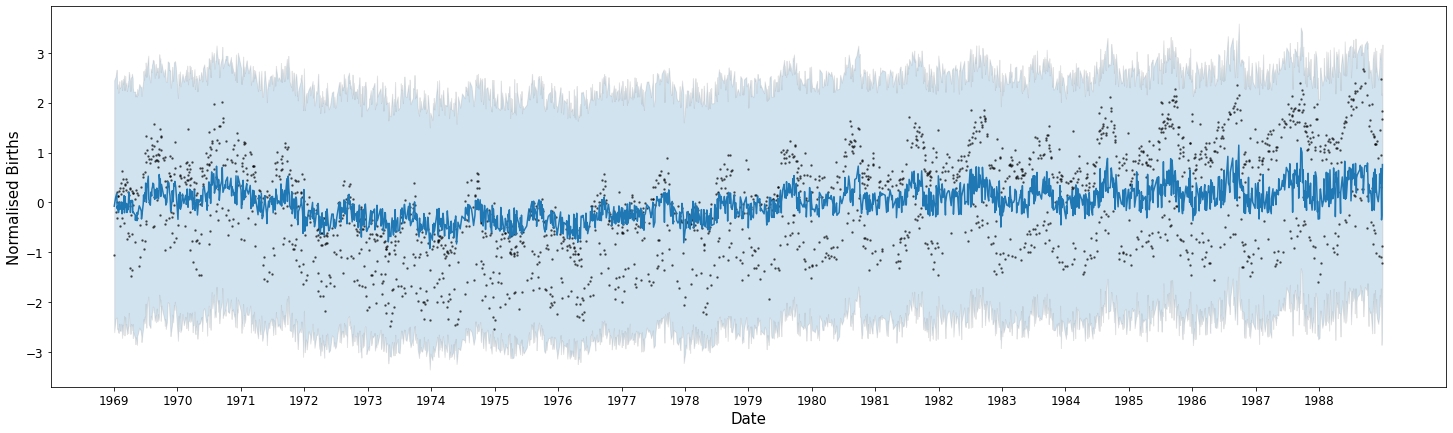

train ELBO, MSE, MAE:  -4515.6470908610745 0.39635303021048607 0.5254652410263925
test ELBO, MSE, MAE:  -5195.889078643248 0.7179241345848606 0.7139538613699167
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
l Distribution:  tfp.distributions.Gamma("Gamma", batch_shape=[], event_shape=[], dtype=float64)
Train


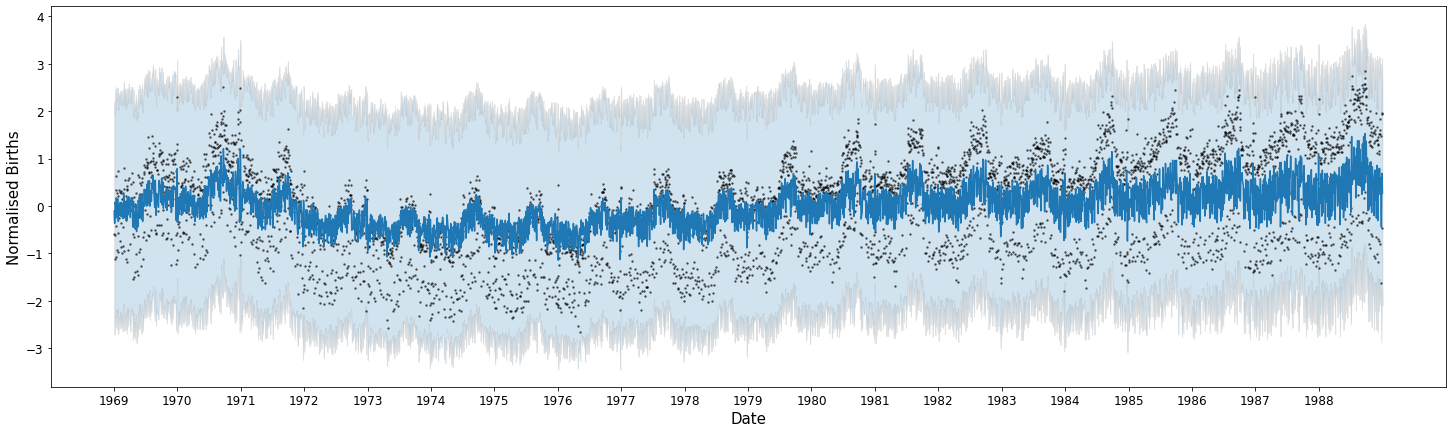

Test


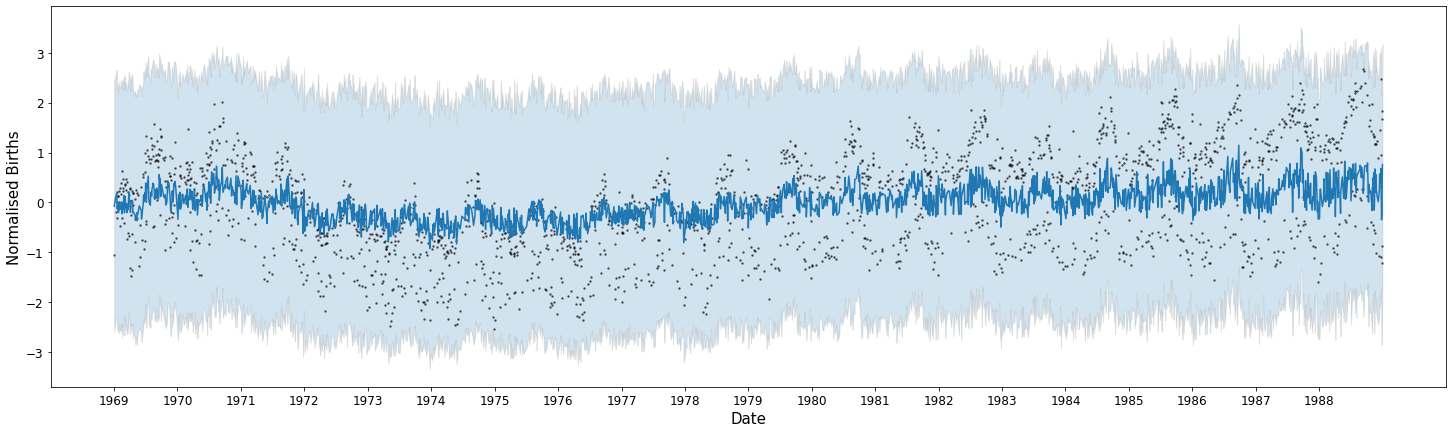

train ELBO, MSE, MAE:  -4515.65205618103 0.3963537187823457 0.5254657174845907
test ELBO, MSE, MAE:  -5195.897776280989 0.7179264010340014 0.7139549820142913
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------


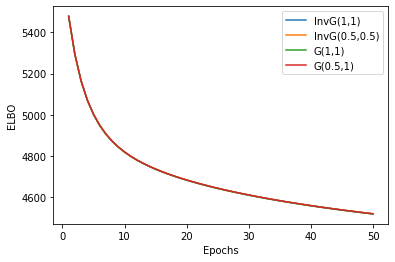

In [4]:
l_dists = [
    tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1)),
    tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(0.5)), 
    tfp.distributions.Gamma(to_default_float(1), to_default_float(1)),
    tfp.distributions.Gamma(to_default_float(0.5), to_default_float(1)),
]

elbos_list = [];

for l_dist in l_dists:
    print('l Distribution: ', l_dist)
    kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), 3000)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=3000)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = l_dist
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    elbos, _, _ = optimise_predict_model(model)
    elbos_list.append(elbos)
    print('--------------------------------------------------------')

fig = plt.figure()
xs = np.linspace(1,50, 50)
plt.plot(xs, elbos_list[0], '-', label='InvG(1,1)')
plt.plot(xs, elbos_list[1], '-', label='InvG(0.5,0.5)')
plt.plot(xs, elbos_list[2], '-', label='G(1,1)')
plt.plot(xs, elbos_list[3], '-', label='G(0.5,1)')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

Different Starting values

l starting value:  1
Train


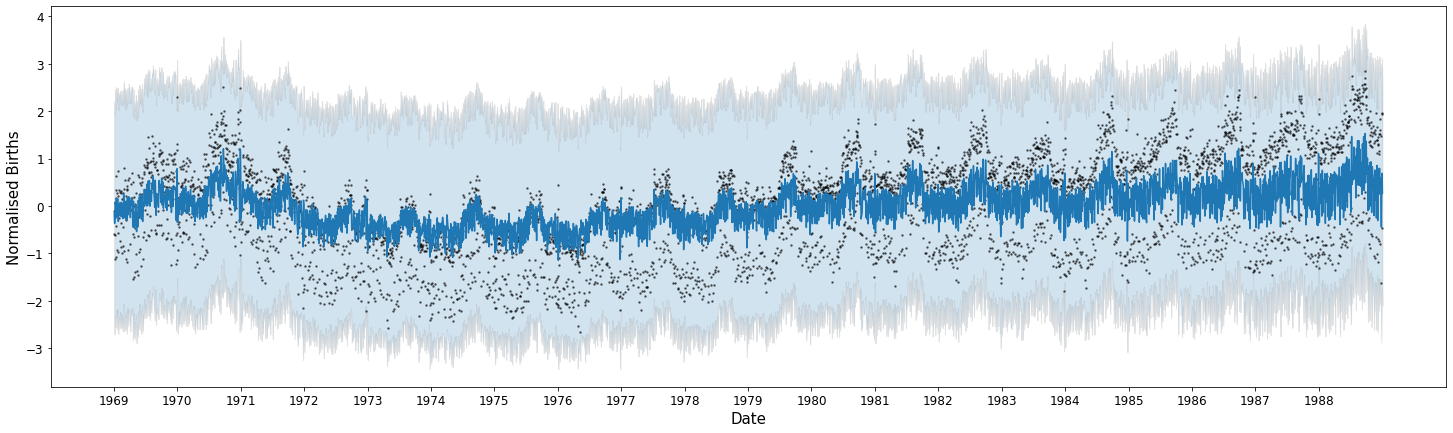

Test


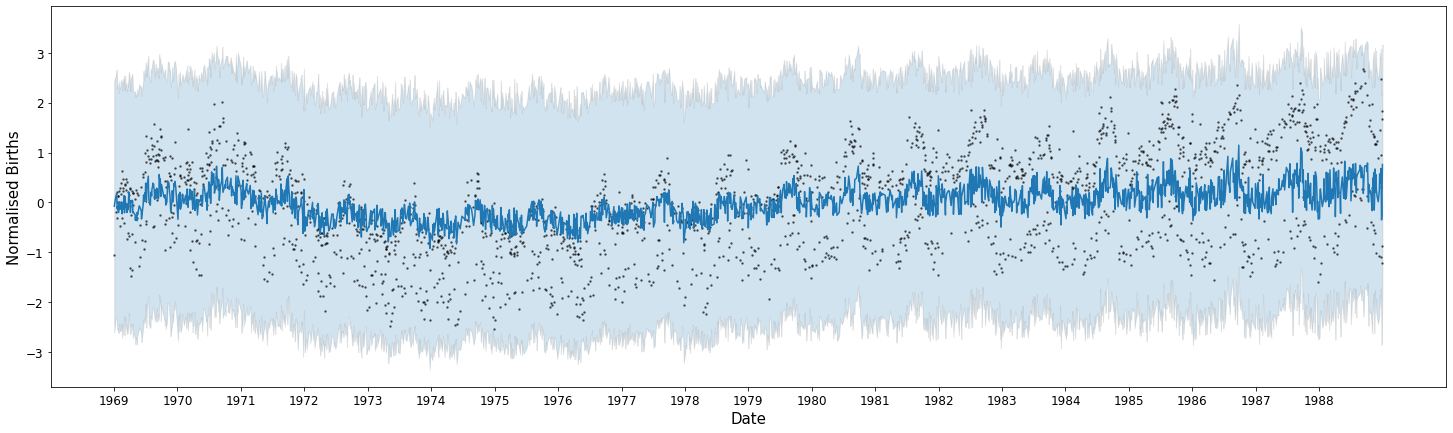

train ELBO, MSE, MAE:  -4515.645271992608 0.396352783735225 0.5254650704519637
test ELBO, MSE, MAE:  -5195.8858627038935 0.7179232997059299 0.7139534512755056
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
l starting value:  3
Train


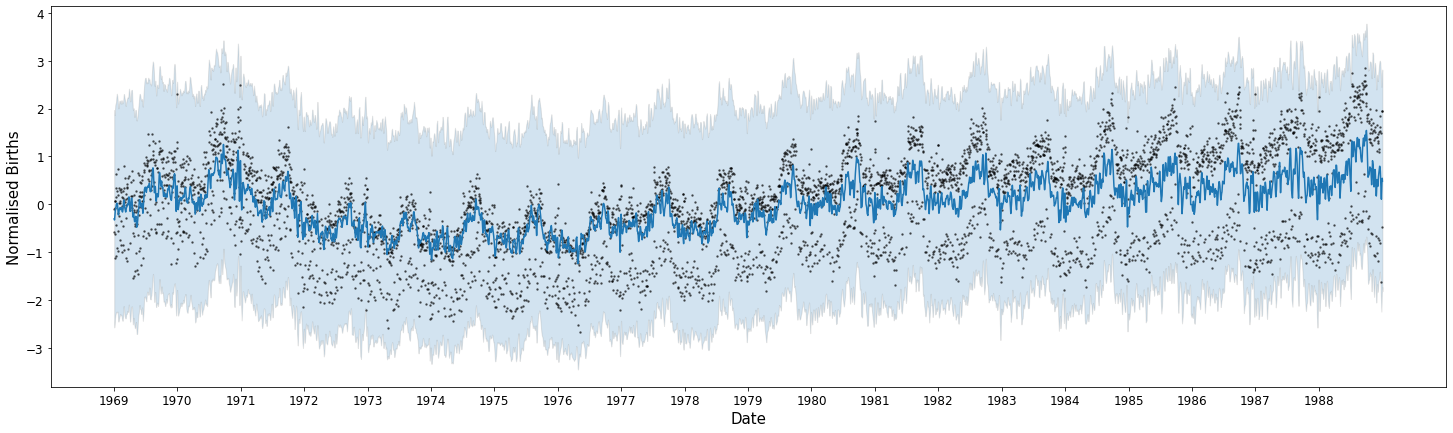

Test


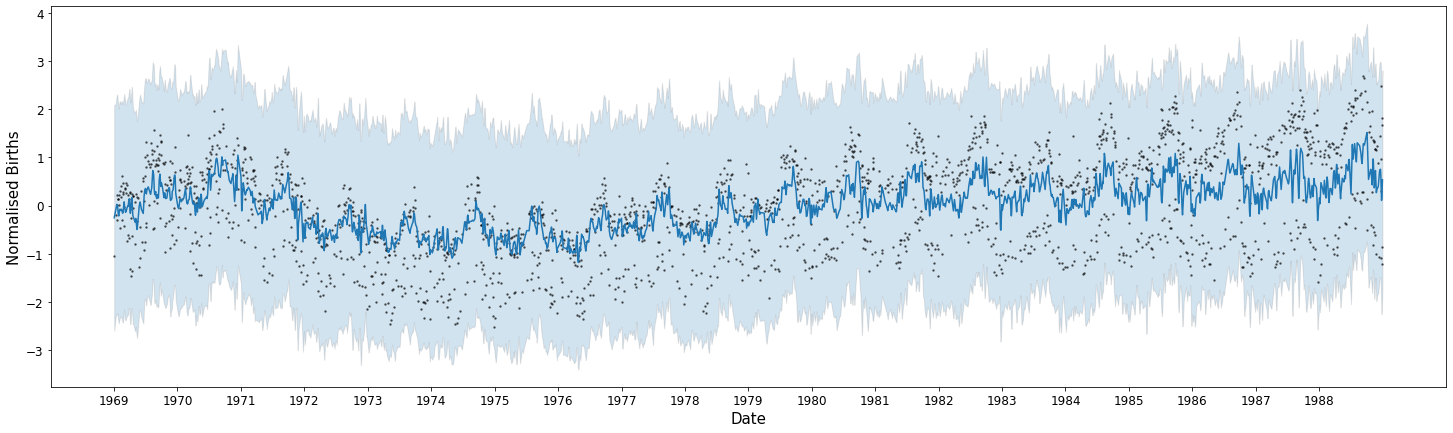

train ELBO, MSE, MAE:  -4342.303436762115 0.5032477708857858 0.5937674918359926
test ELBO, MSE, MAE:  -4776.083665111235 0.7354846093844636 0.7228881306085948
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
l starting value:  5
Train


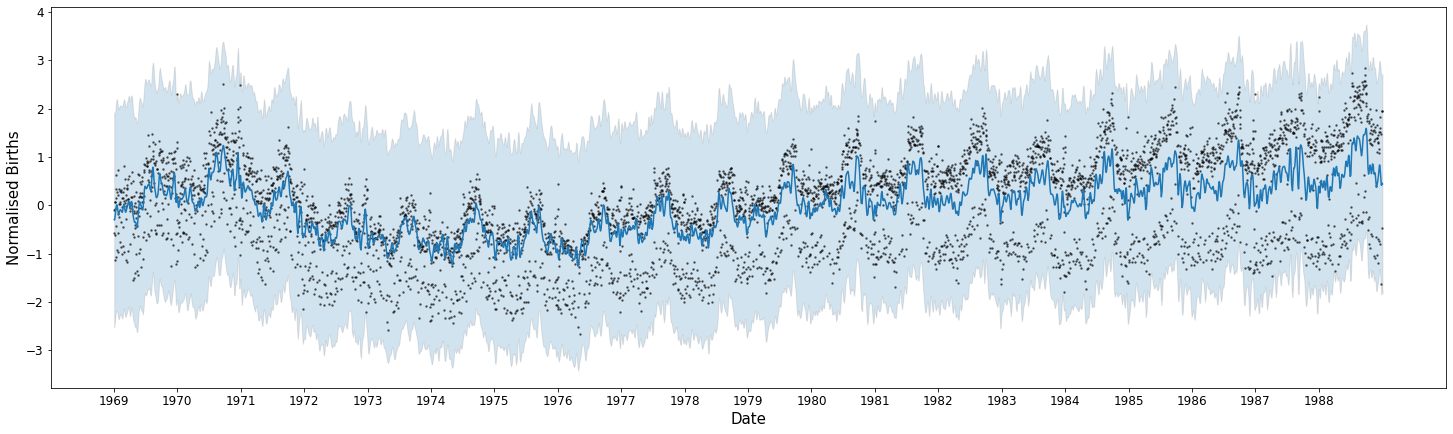

Test


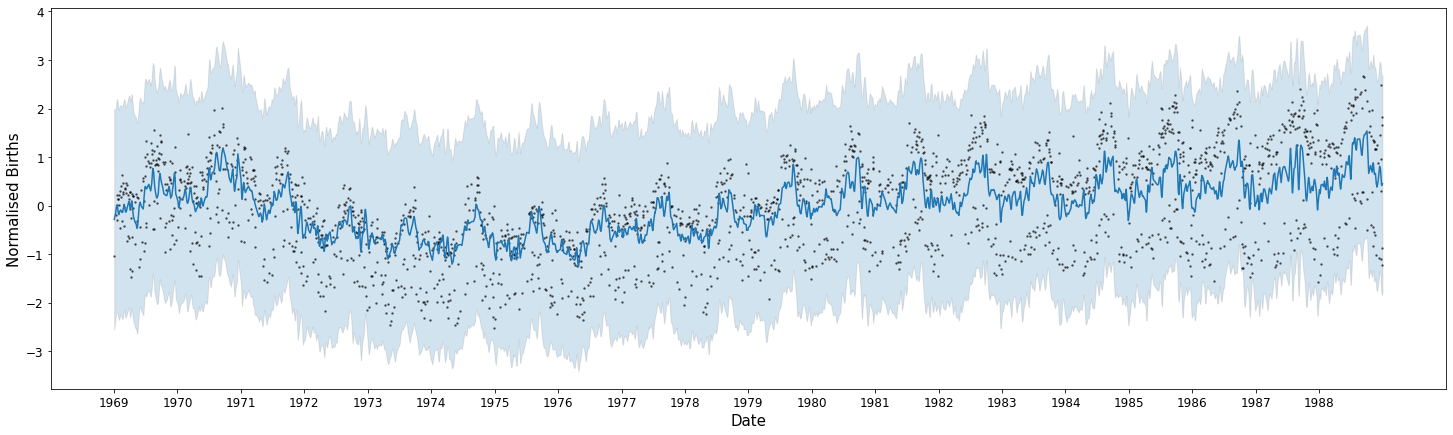

train ELBO, MSE, MAE:  -4215.233928543934 0.5223317779816152 0.6058944505749454
test ELBO, MSE, MAE:  -4518.242679788799 0.6927911718183101 0.7009813520604212
percentage out of CI (train, test):  0.019557989438685704 0.0


--------------------------------------------------------
l starting value:  7
Train


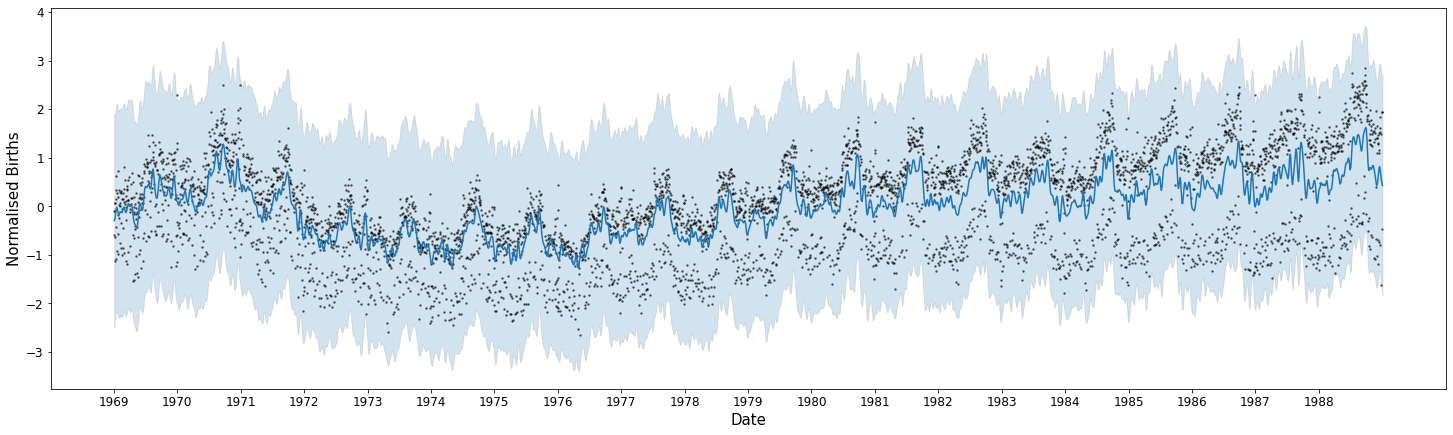

Test


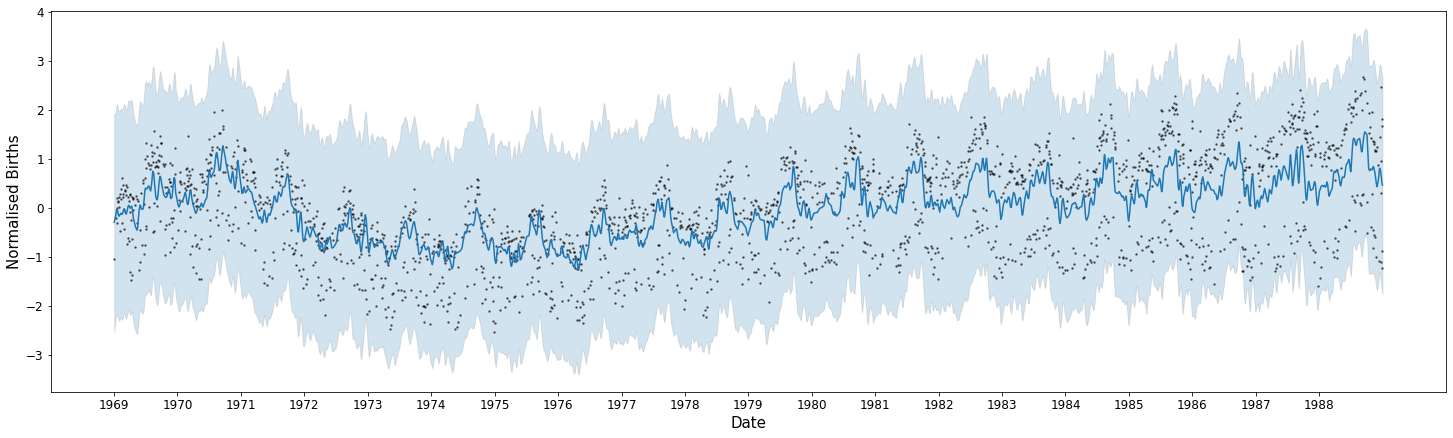

train ELBO, MSE, MAE:  -4128.61231275047 0.5261769689060998 0.6090785342681906
test ELBO, MSE, MAE:  -4360.747442132701 0.6604616308518155 0.6846468685007279
percentage out of CI (train, test):  0.03911597887737141 0.04562043795620438


--------------------------------------------------------
l starting value:  10
Train


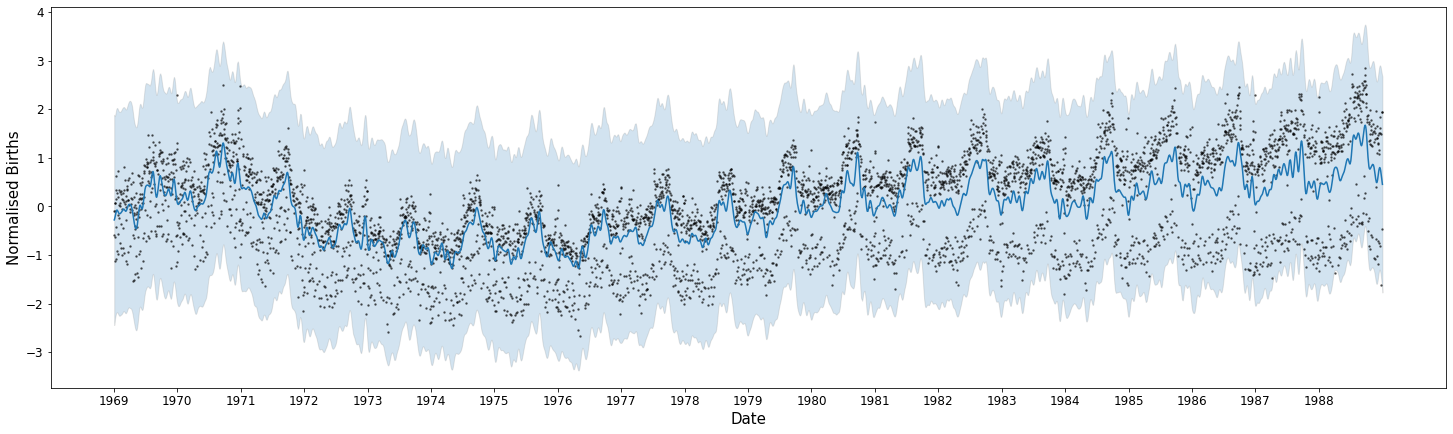

Test


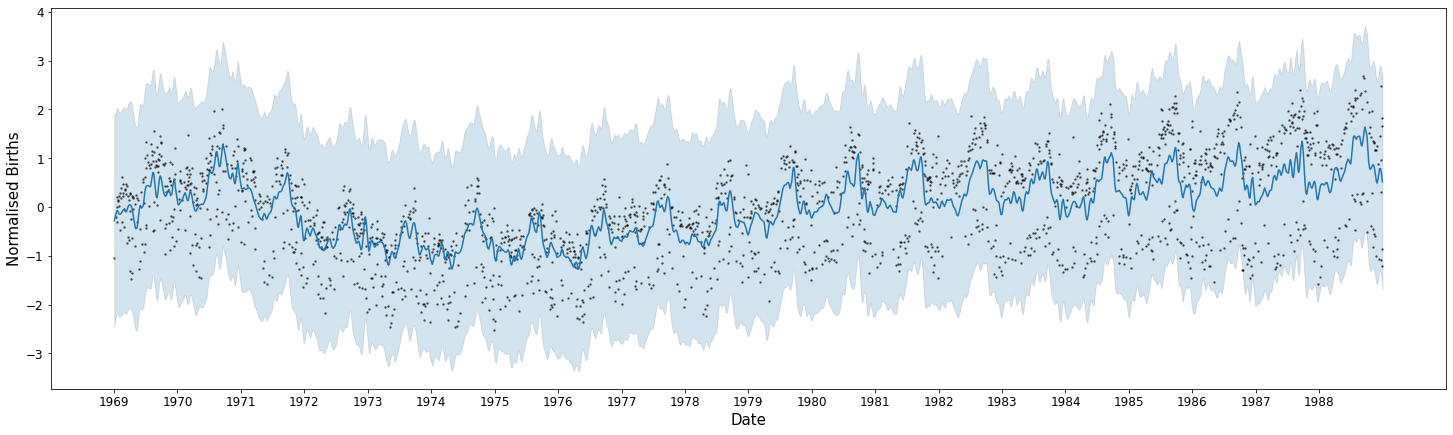

train ELBO, MSE, MAE:  -4042.047462324018 0.5297075838302192 0.6126330425113252
test ELBO, MSE, MAE:  -4216.596035769164 0.6335815870611112 0.6712592031839578
percentage out of CI (train, test):  0.07823195775474281 0.04562043795620438


--------------------------------------------------------


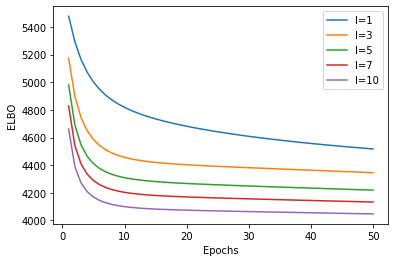

In [5]:
ls = [1, 3, 5, 7, 10]

elbos_list = [];

for l in ls:
    print('l starting value: ', l)
    kernel = gpflow.kernels.RBF(lengthscales = l, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), 3000)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=3000)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    elbos, _, _ = optimise_predict_model(model)
    elbos_list.append(elbos)
    print('--------------------------------------------------------')

fig = plt.figure()
xs = np.linspace(1,50, 50)
plt.plot(xs, elbos_list[0], '-', label='l=1')
plt.plot(xs, elbos_list[1], '-', label='l=3')
plt.plot(xs, elbos_list[2], '-', label='l=5')
plt.plot(xs, elbos_list[3], '-', label='l=7')
plt.plot(xs, elbos_list[4], '-', label='l=10')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

Number of inducing points M

Inducing points:  1500
Train


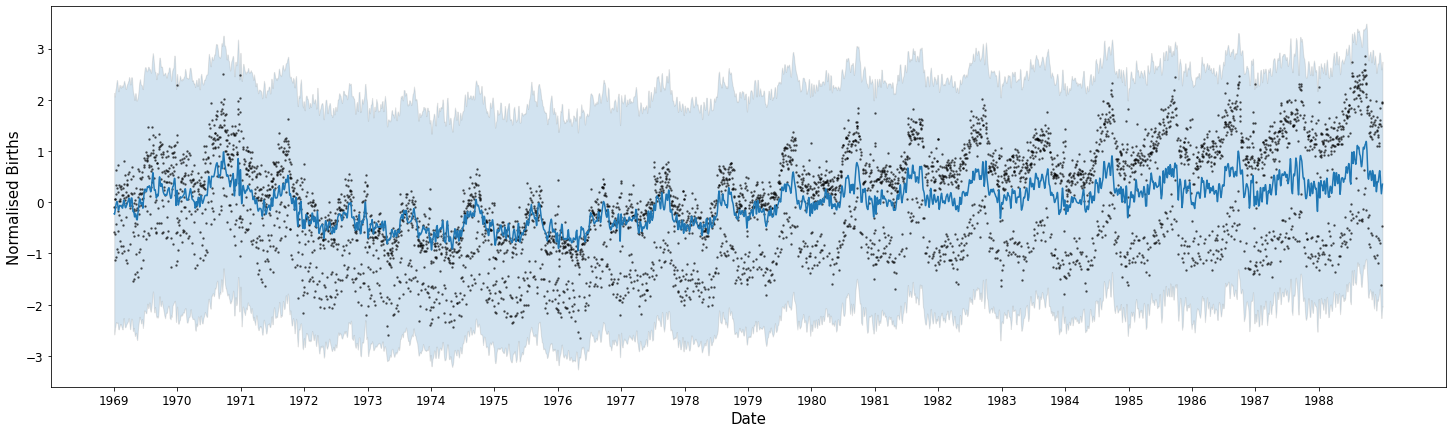

Test


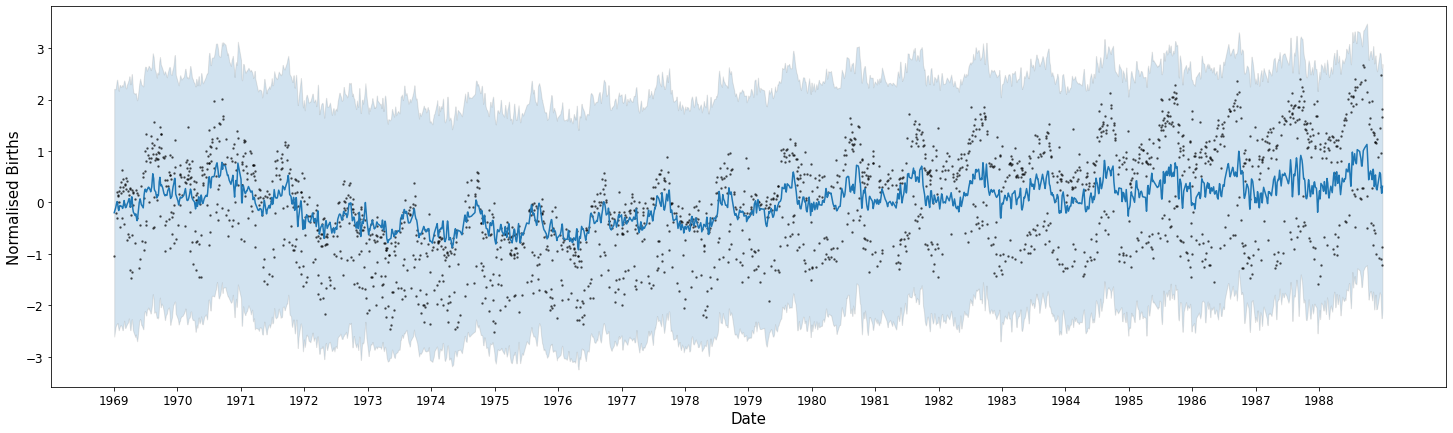

train ELBO, MSE, MAE:  -2311.144971144707 0.5852783235319567 0.6413499866543669
test ELBO, MSE, MAE:  -2476.4992010183437 0.7551531612469665 0.7340412073087614
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------
Inducing points:  3000
Train


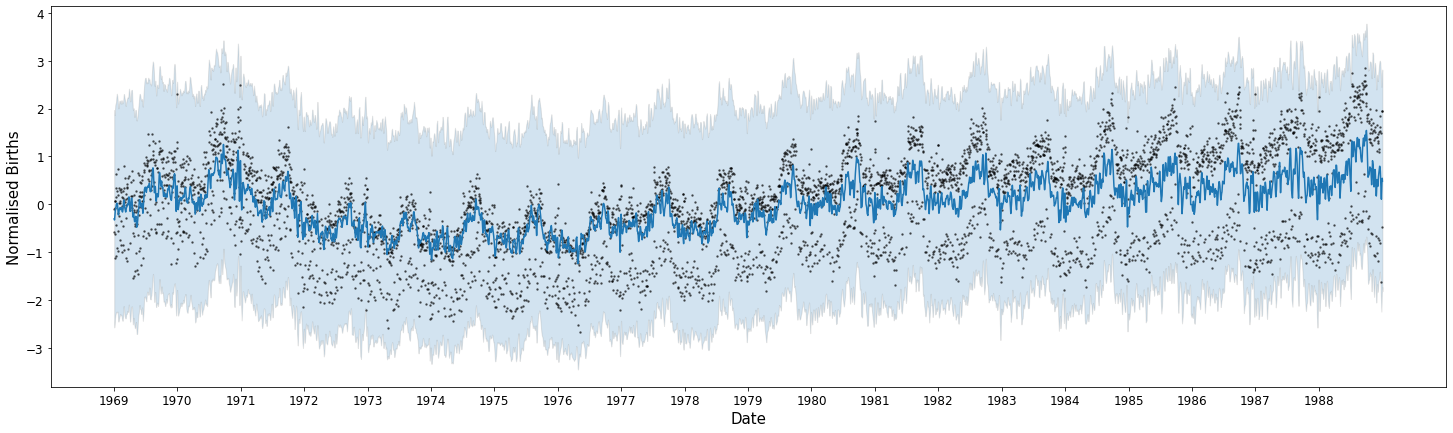

Test


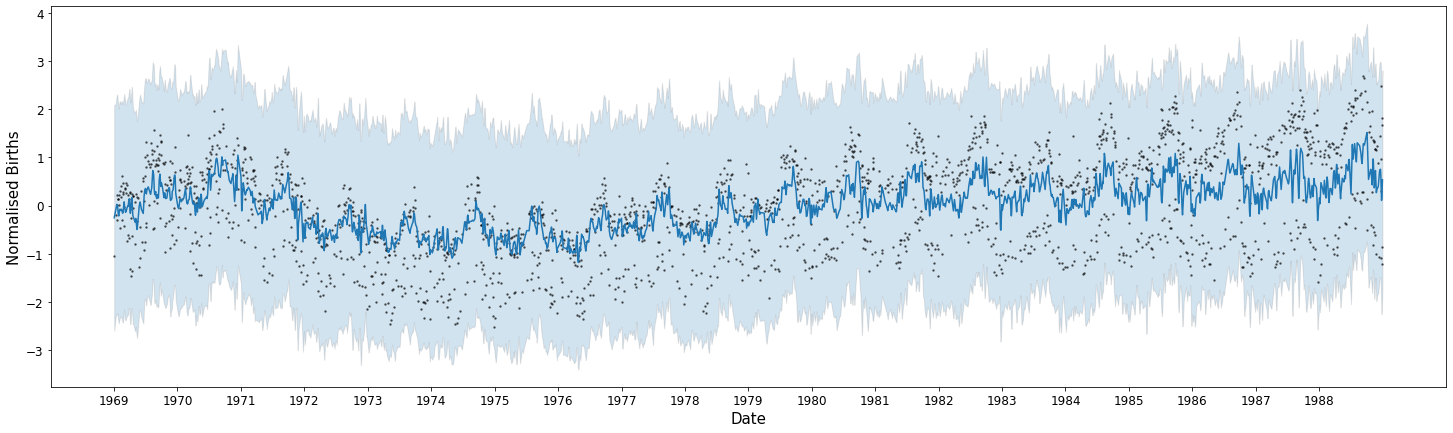

train ELBO, MSE, MAE:  -4342.303436762115 0.5032477708857858 0.5937674918359926
test ELBO, MSE, MAE:  -4776.083665111235 0.7354846093844636 0.7228881306085948
percentage out of CI (train, test):  0.0 0.0


--------------------------------------------------------


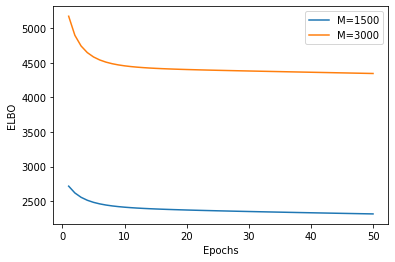

In [6]:
Ms = [1500, 3000]

elbos_list = [];

for M in Ms:
    print('Inducing points: ', M)
    kernel = gpflow.kernels.RBF(lengthscales = 3, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    elbos, _, _ = optimise_predict_model(model)
    elbos_list.append(elbos)
    print('--------------------------------------------------------')

fig = plt.figure()
xs = np.linspace(1,50, 50)
plt.plot(xs, elbos_list[0], '-', label='M=1500')
plt.plot(xs, elbos_list[1], '-', label='M=3000')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

Training vs not training Z

Train Z
Train


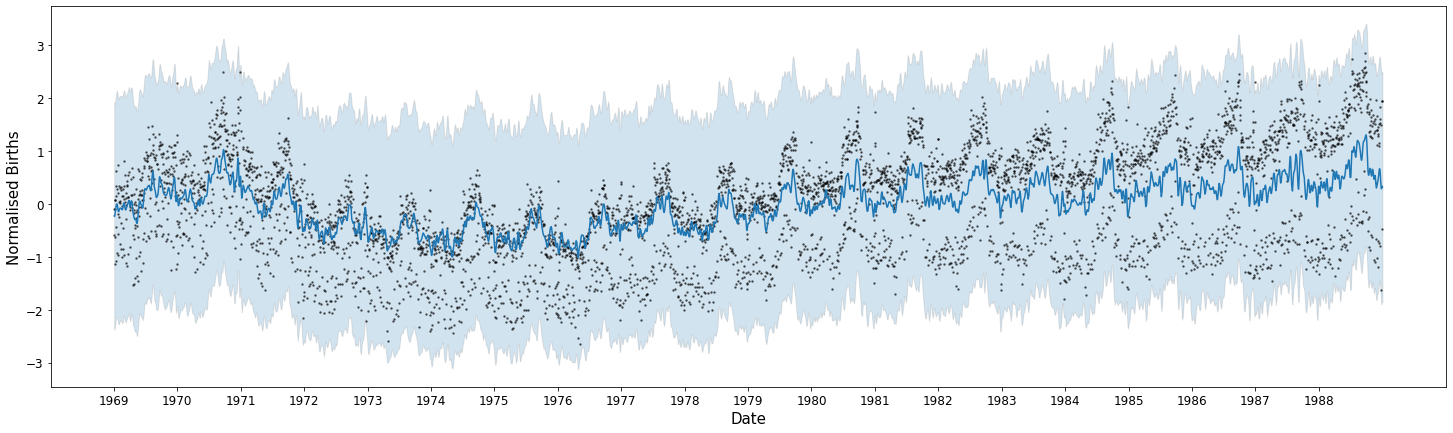

Test


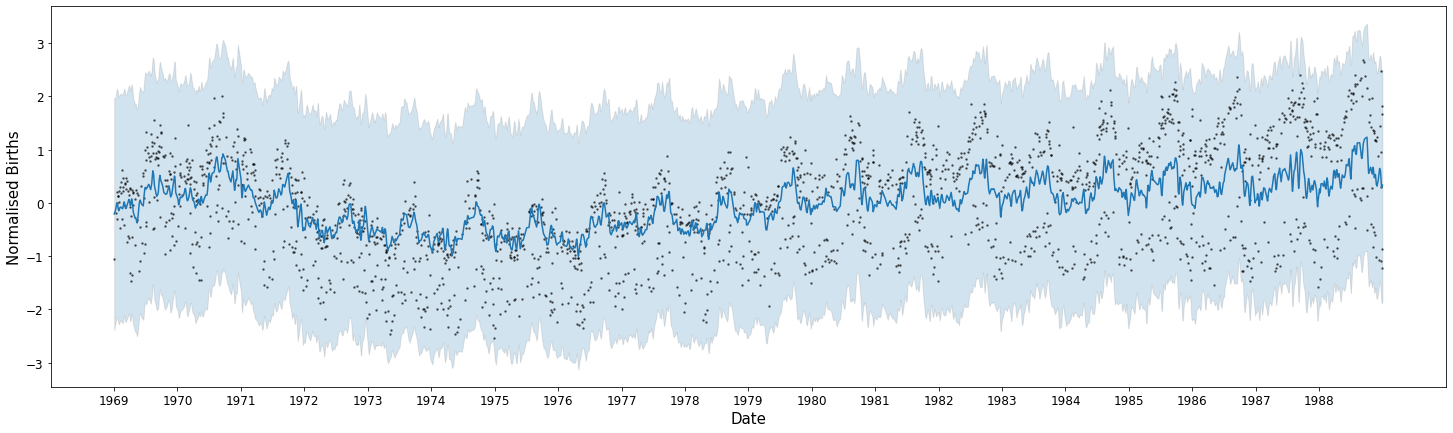

train ELBO, MSE, MAE:  -4145.876633126645 0.5659930580424831 0.6307670365907279
test ELBO, MSE, MAE:  -4394.727472478027 0.7124046734159722 0.7120917249842466
percentage out of CI (train, test):  0.03911597887737141 0.0


--------------------------------------------------------
Dont train Z
Train


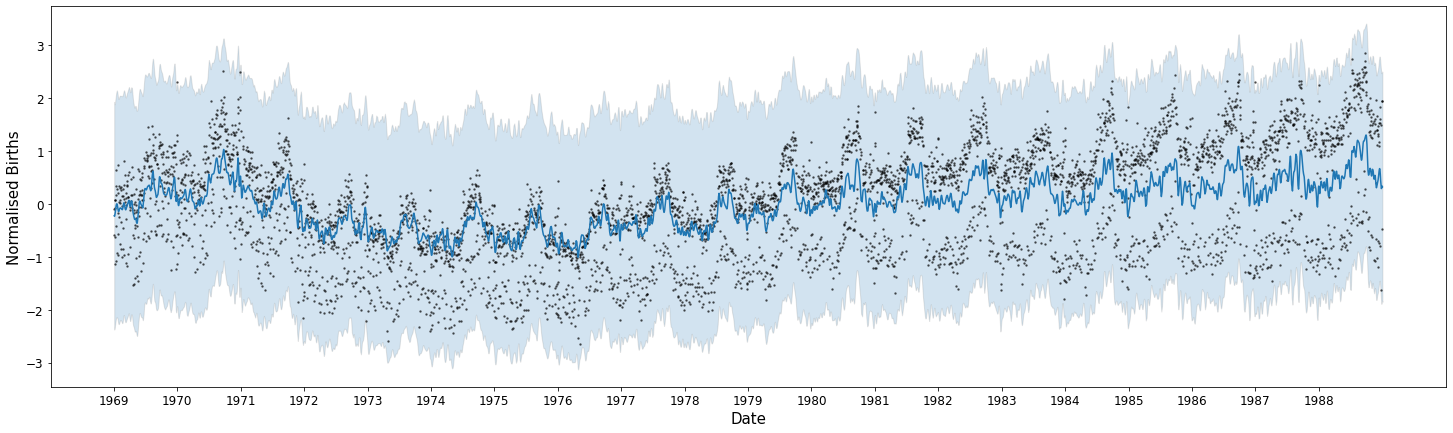

Test


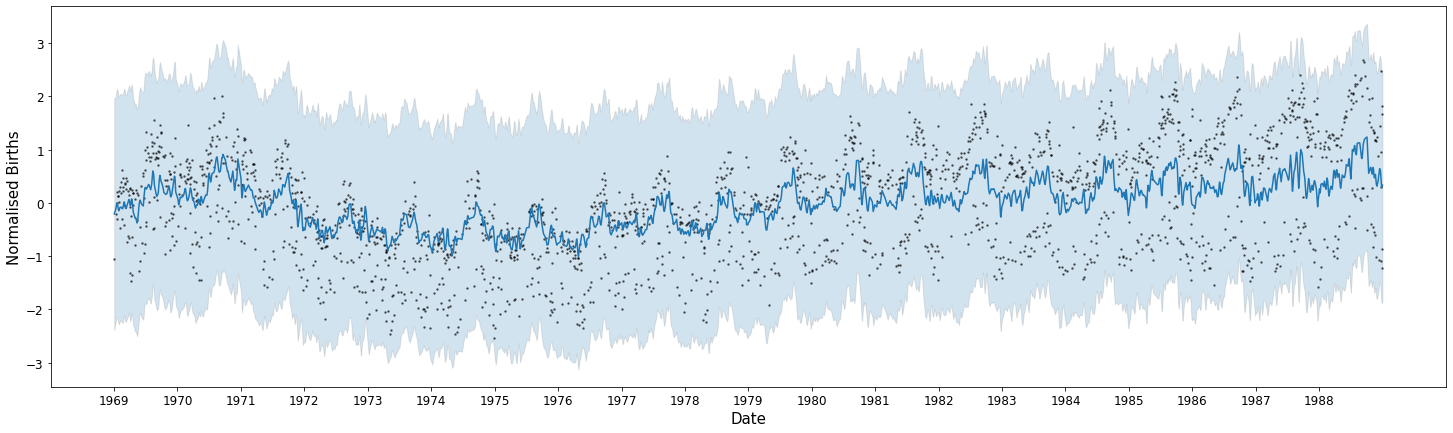

train ELBO, MSE, MAE:  -4145.966280766848 0.5661250845184612 0.6308559010687669
test ELBO, MSE, MAE:  -4394.8020021627635 0.7125296816434986 0.7121826299860797
percentage out of CI (train, test):  0.03911597887737141 0.0


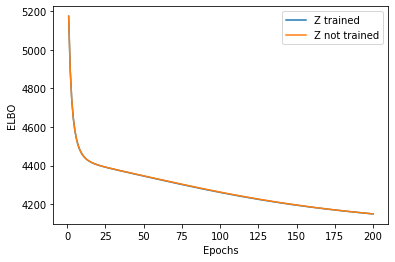

In [7]:
elbos_list = []
M = 3000

print('Train Z')
kernel = gpflow.kernels.RBF(lengthscales = 3, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model1 = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model1.likelihood.variance, False)
set_trainable(model1.inducing_variable.Z, True)
model1.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model1.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
elbos,_,_ = optimise_predict_model(model1, epochs=200)
elbos_list.append(elbos)

Z_save = Z
Z_learnt_save = model1.inducing_variable.Z
print('--------------------------------------------------------')

print('Dont train Z')
kernel = gpflow.kernels.RBF(lengthscales = 3, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model2 = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model2.likelihood.variance, False)
set_trainable(model2.inducing_variable.Z, False)
model2.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model2.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
elbos,_,_ = optimise_predict_model(model2,  epochs=200)
elbos_list.append(elbos)

fig = plt.figure()
xs = np.linspace(1,200, 200)
plt.plot(xs, elbos_list[0], '-', label='Z trained')
plt.plot(xs, elbos_list[1], '-', label='Z not trained')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

Try the set up: epochs=1000, l=3, M=3000, Z trained

Train


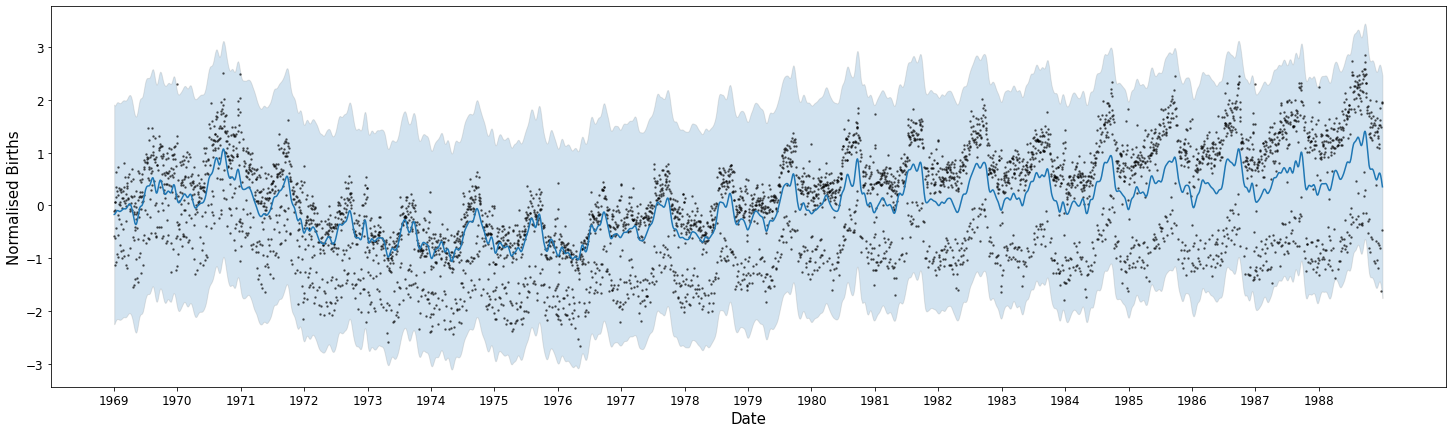

Test


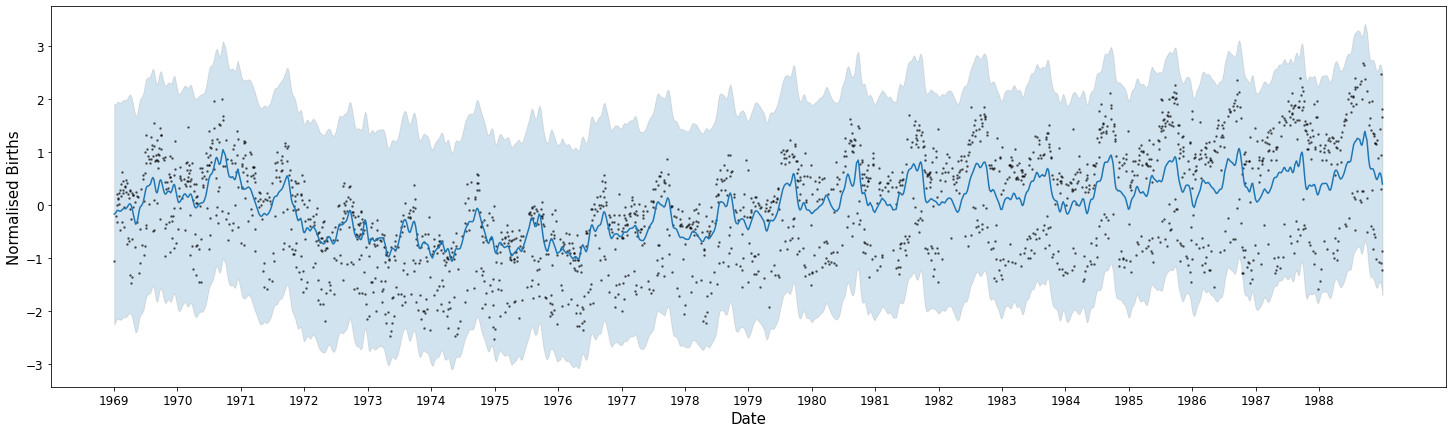

train ELBO, MSE, MAE:  -3939.815462739738 0.559299312620549 0.6290249174686077
test ELBO, MSE, MAE:  -4055.3295569543707 0.6313558895808258 0.6694052029775148
percentage out of CI (train, test):  0.058673968316057104 0.0


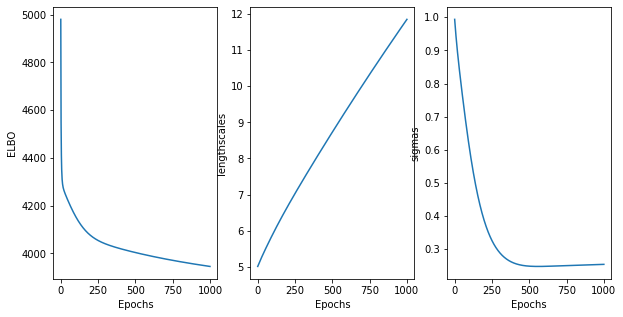

In [12]:
M = 3000
kernel = gpflow.kernels.RBF(lengthscales = 5, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
set_trainable(model.inducing_variable.Z, True)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
elbos, ls, sigmas = optimise_predict_model(model, epochs=1000)


fig, ax = plt.subplots(1,3, figsize=(10,5))
xs = np.linspace(1,1000, 1000)
ax[0].plot(xs, elbos, '-')
ax[1].plot(xs, ls, '-')
ax[2].plot(xs, sigmas, '-')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[2].set_xlabel('Epochs')
ax[0].set_ylabel('ELBO')
ax[1].set_ylabel('lengthscales')
ax[2].set_ylabel('sigmas')
plt.show()